In [1]:
import SNIDsn
import SNIDdataset as snid
import numpy as np
import SNePCA

import plotly.plotly as ply
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.pyplot as plt

import pandas
from BinSpectra import lowres_dataset
from BinSpectra import random_noise_dataset
from BinSpectra import fake_spectra_dataset
from BinSpectra import replace_flux_with_fake_feature
from BinSpectra import ArangeSNeType
import warnings
from progress.bar import Bar
import random
np.set_printoptions(threshold=np.inf)

#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
PATH = '../Data/DataProducts/'

In [2]:
def loaddata(phase):
    """
    Loads the pickled dataset
    """
    dsname = "dataset{}.pickle".format(phase)
    return snid.loadPickle(PATH + dsname)   


def get_bin_length(phase, bin_factor):
    dataset = loaddata(phase)
    dataset_key_list = list(dataset.keys())
    wvl = dataset[dataset_key_list[0]].wavelengths
    wbin = (np.log(wvl[1]) - np.log(wvl[0])) * bin_factor
    return wbin



def runPCA(phase, bin_length, dphase=5, fake=True):
    dataset = loaddata(phase)
    if fake:
        dataset = replace_flux_with_fake_feature(dataset)
        dataset_lowres = lowres_dataset(dataset, bin_length)
    else:
        dataset_lowres = lowres_dataset(dataset, bin_length)
    snidPCA_ph = SNePCA.SNePCA(dataset_lowres, phase - dphase, phase + dphase)
    snidPCA_ph.snidPCA()
    snidPCA_ph.calcPCACoeffs()
    return snidPCA_ph


def runSVM_plot(phase, pcax, pcay, figure=True):
    warnings.filterwarnings('ignore')
    av_svm_score_dict = {}
    av_svm_std = {}
    bin_length_list = []
    bf_list = list(np.arange(1., 83., 9.))
    exclude = ['sn2007uy', 'sn2009er', 'sn2005ek']
    for bf in bf_list:
        bin_length = get_bin_length(phase, bf)
        snidPCA = runPCA(phase, bin_length)
        svmsc,av,std=snidPCA.runSVM(pcax,pcay,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,purity=True,
                                               excludeSNe=exclude,std_rad=1.0,svm=True,count=3,
                                               fig=None,ax=None,ncv=50,markOutliers=True)
        av_svm_score_dict.setdefault('PC%d vs PC%d'%(pcax, pcay), []).append(av)
        av_svm_std.setdefault('PC%d vs PC%d'%(pcax, pcay), []).append(std)
        bin_length_list.append(bin_length)
    bin_length_array = np.array(bin_length_list)
    if figure:
        plt.figure(figsize=(20,10))
        pcstring = "PC{} vs PC{}".format(pcax, pcay)
        plt.plot(bin_length_array, av_svm_score_dict[pcstring], color='b', label =pcstring, linewidth=7)
        plt.errorbar(bin_length_array, av_svm_score_dict[pcstring], linewidth = 7,  yerr = av_svm_std[pcstring], elinewidth = 7)
        plt.xlabel('Bin length', fontsize=44)
        plt.ylabel('Average SVM Score', fontsize=44)
        plt.tick_params(axis='both', which='major', labelsize=44)
        plt.legend(fontsize=42)
        plt.tight_layout()
        plt.savefig('pca_svm_%d.pdf'%phase)
    return bin_length_array, av_svm_score_dict, av_svm_std, svmsc

# 1. Sample Spectrum 1: 

## All four classes has a very distinctive feature. Each class has a feature with different depth and in diferent bin. The classifier should be able to distinct between them and should give an accuracy score of 1. At lower resolution, the features become wide and start to overlap each other and become less distinctive. The accuracy score should decrease but they are still distinctive, the classifier should still be able to classify them but with a relatively low accuracy score. 

## 1.1 Full resolution

In [3]:
bfs = list(np.arange(1., 83., 9.))
bf = bfs[-1]
bin_length = get_bin_length(0, bf)
dataset = replace_flux_with_fake_feature(loaddata(10))
lowres = lowres_dataset(dataset, bin_length)
dataset = replace_flux_with_fake_feature(loaddata(10))

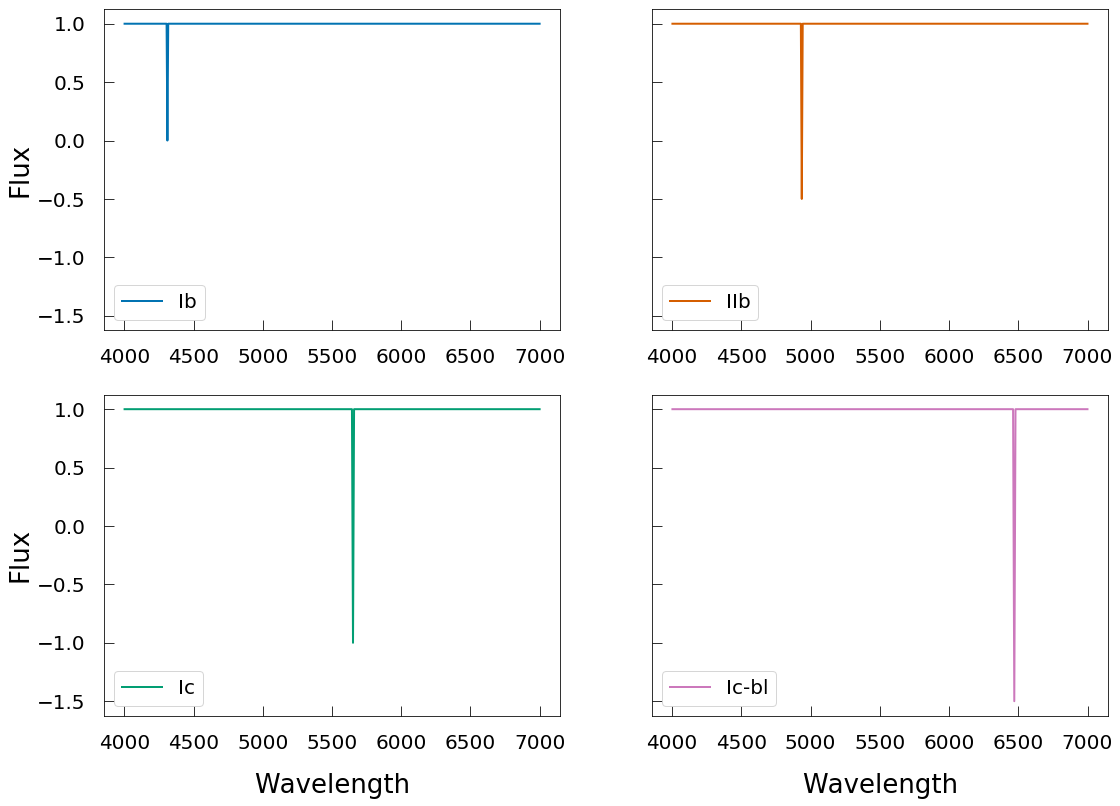

In [4]:
f_all, axs = plt.subplots(2,2,figsize=(18,13), sharey=True, gridspec_kw={'hspace':.2})
axs = axs.flatten()
keys = list(dataset.keys())
wvl_1 = dataset[keys[0]].wavelengths
flux_1 = dataset[keys[0]].data.astype('float64')
wvl_2 = dataset[keys[25]].wavelengths
flux_2 = dataset[keys[25]].data
wvl_3 = dataset[keys[34]].wavelengths
flux_3 = dataset[keys[34]].data
wvl_4 = dataset[keys[50]].wavelengths
flux_4 = dataset[keys[50]].data
axs[0].plot(wvl_1, flux_1, color='b', label ="Ib", linewidth=2)
axs[1].plot(wvl_2, flux_2, color='r', label ="IIb", linewidth=2)
axs[2].plot(wvl_3, flux_3, color='g', label ="Ic", linewidth=2)
axs[3].plot(wvl_4, flux_4, color='m', label ="Ic-bl", linewidth=2)
axs[0].set_ylabel('Flux', fontsize=26)
axs[2].set_ylabel('Flux', fontsize=26)
axs[2].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[3].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[0].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[1].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[2].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[3].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)

## 1.2 Lowest resolution

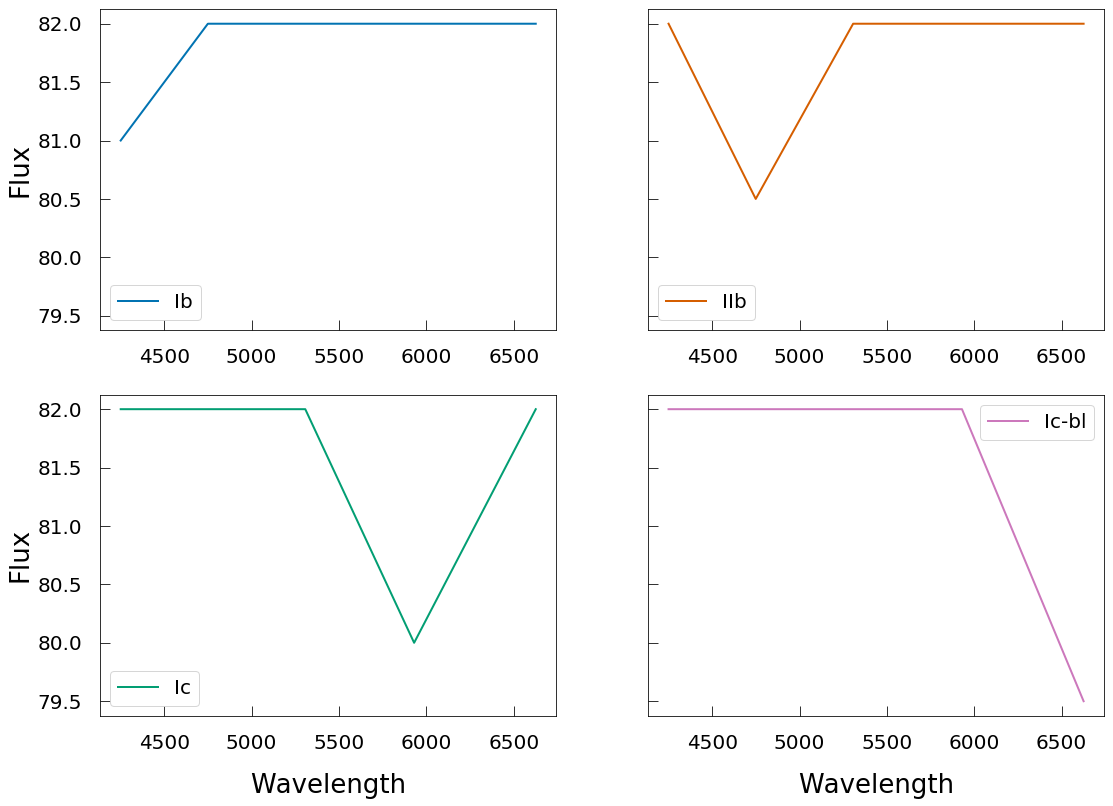

In [5]:
f_all, axs = plt.subplots(2,2,figsize=(18,13), sharey=True, gridspec_kw={'hspace':.2})
axs = axs.flatten()
keys = list(dataset.keys())
wvl_1 = lowres[keys[0]].wavelengths
flux_1 = lowres[keys[0]].data.astype('float64')
wvl_2 = lowres[keys[25]].wavelengths
flux_2 = lowres[keys[25]].data
wvl_3 = lowres[keys[34]].wavelengths
flux_3 = lowres[keys[34]].data
wvl_4 = lowres[keys[50]].wavelengths
flux_4 = lowres[keys[50]].data
axs[0].plot(wvl_1, flux_1, color='b', label ="Ib", linewidth=2)
axs[1].plot(wvl_2, flux_2, color='r', label ="IIb", linewidth=2)
axs[2].plot(wvl_3, flux_3, color='g', label ="Ic", linewidth=2)
axs[3].plot(wvl_4, flux_4, color='m', label ="Ic-bl", linewidth=2)
axs[0].set_ylabel('Flux', fontsize=26)
axs[2].set_ylabel('Flux', fontsize=26)
axs[2].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[3].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[0].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[1].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[2].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[3].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)

## 1.3 SVM Score

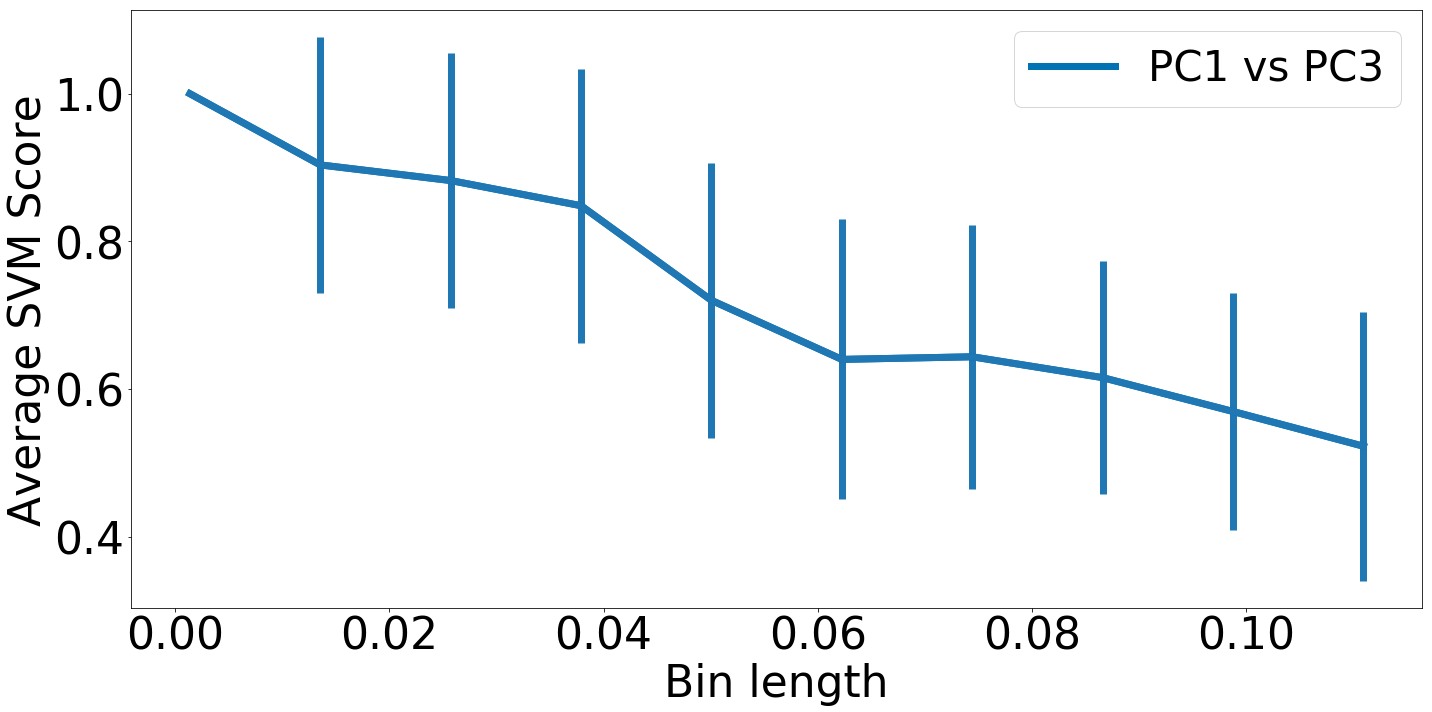

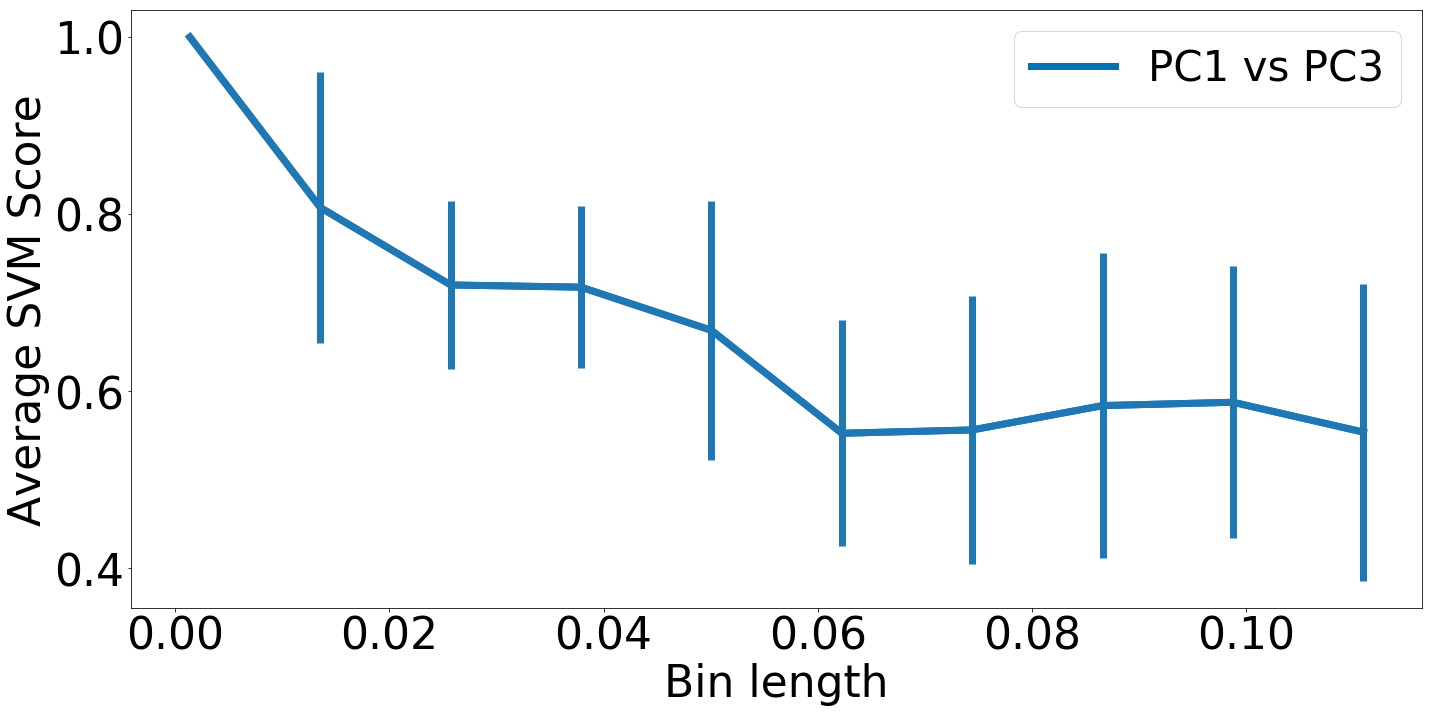

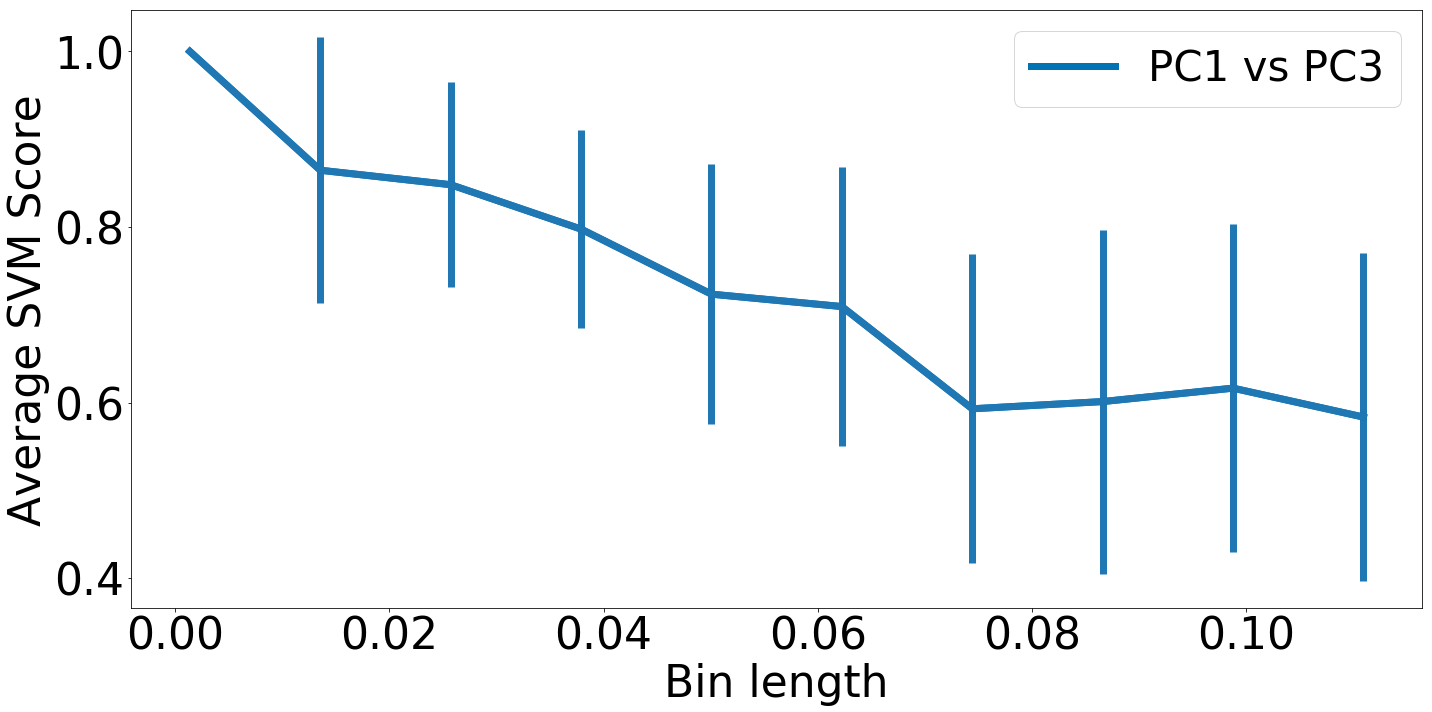

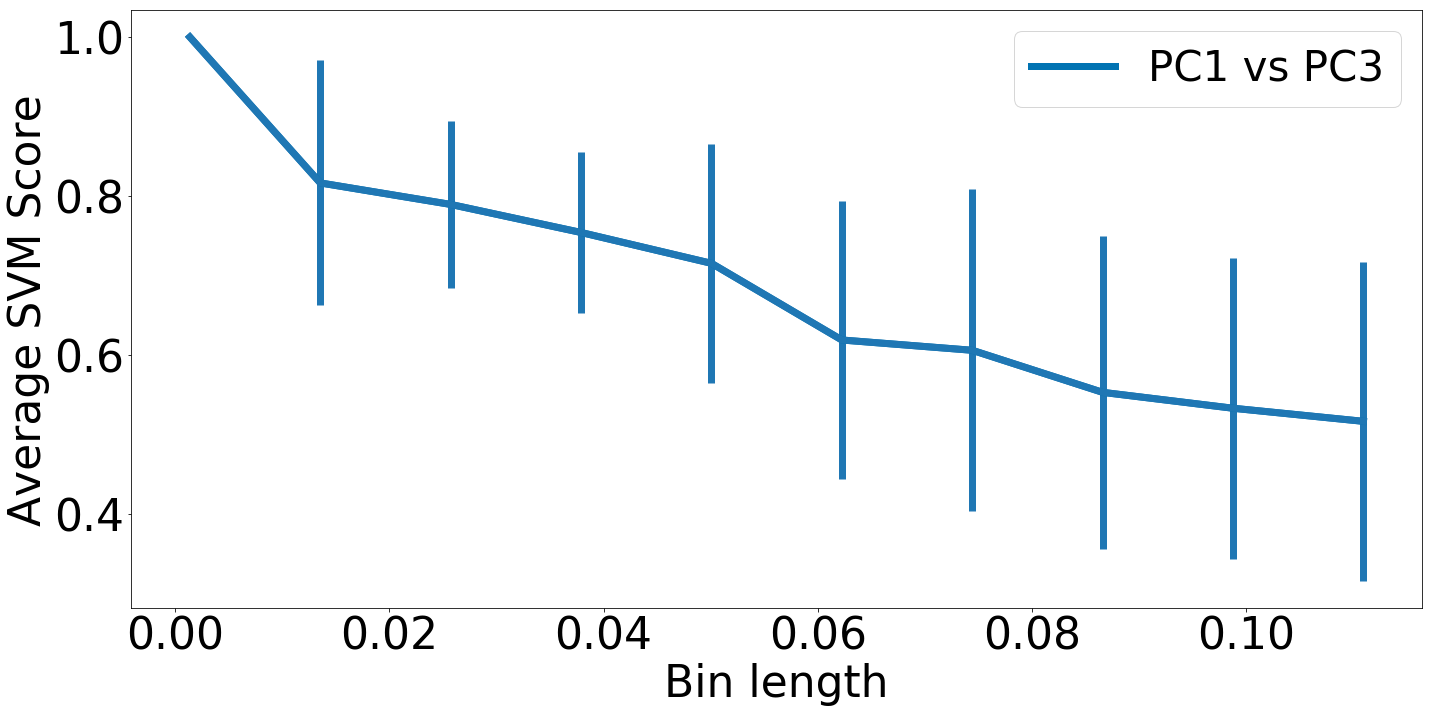

In [6]:
svm_score_0 = runSVM_plot(0, pcax=1, pcay=3)
svm_score_5 = runSVM_plot(5, pcax=1, pcay=3)
svm_score_10 = runSVM_plot(10, pcax=1, pcay=3)
svm_score_15 = runSVM_plot(15, pcax=1, pcay=3)

# 2. Sample Spectrum 2

## All four classes have same spectrum: same feature at same wavelength bin. There is no distinction at all. The classifier will give accuracy scores as that of random noise. Also the SVM scores should not be affected by the resolution. 

## 2.1 Full resolution

In [3]:
bfs = list(np.arange(1., 83., 9.))
bf = bfs[-1]
bin_length = get_bin_length(0, bf)
dataset = replace_flux_with_fake_feature(loaddata(10))
lowres = lowres_dataset(dataset, bin_length)
dataset = replace_flux_with_fake_feature(loaddata(10))

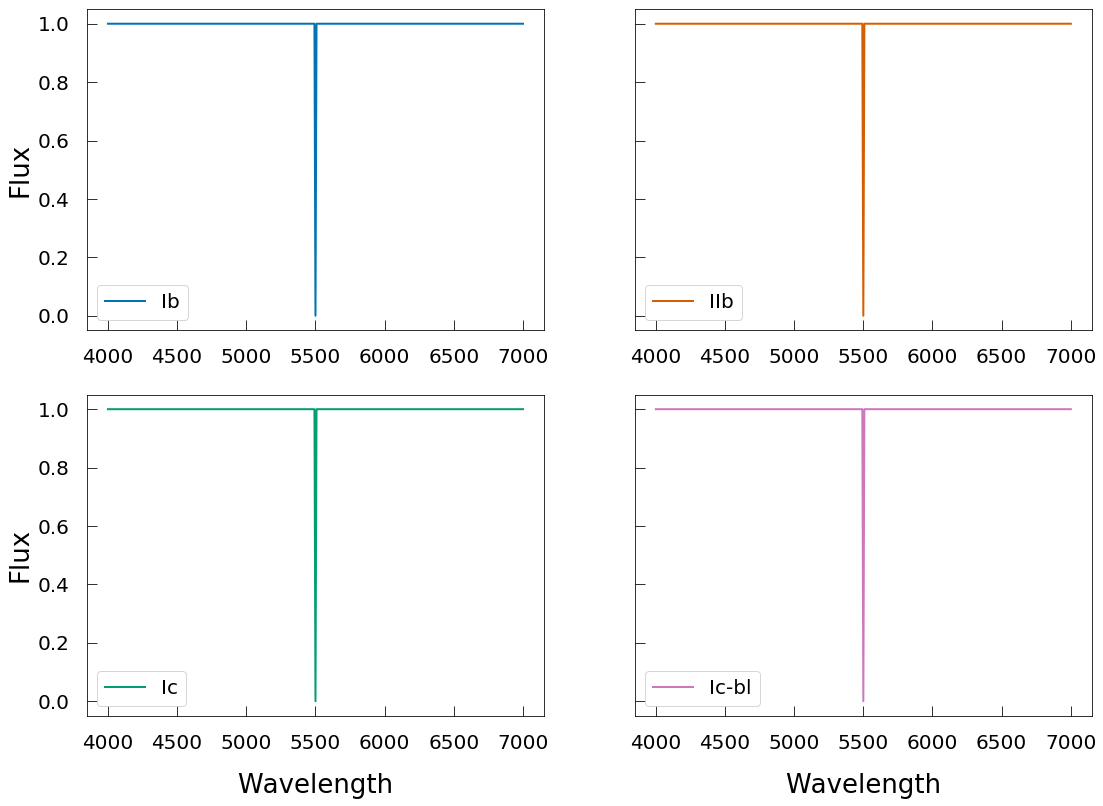

In [4]:
f_all, axs = plt.subplots(2,2,figsize=(18,13), sharey=True, gridspec_kw={'hspace':.2})
axs = axs.flatten()
keys = list(dataset.keys())
wvl_1 = dataset[keys[0]].wavelengths
flux_1 = dataset[keys[0]].data.astype('float64')
wvl_2 = dataset[keys[25]].wavelengths
flux_2 = dataset[keys[25]].data
wvl_3 = dataset[keys[34]].wavelengths
flux_3 = dataset[keys[34]].data
wvl_4 = dataset[keys[50]].wavelengths
flux_4 = dataset[keys[50]].data
axs[0].plot(wvl_1, flux_1, color='b', label ="Ib", linewidth=2)
axs[1].plot(wvl_2, flux_2, color='r', label ="IIb", linewidth=2)
axs[2].plot(wvl_3, flux_3, color='g', label ="Ic", linewidth=2)
axs[3].plot(wvl_4, flux_4, color='m', label ="Ic-bl", linewidth=2)
axs[0].set_ylabel('Flux', fontsize=26)
axs[2].set_ylabel('Flux', fontsize=26)
axs[2].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[3].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[0].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[1].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[2].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[3].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)

## 2.2 Lowest resolution

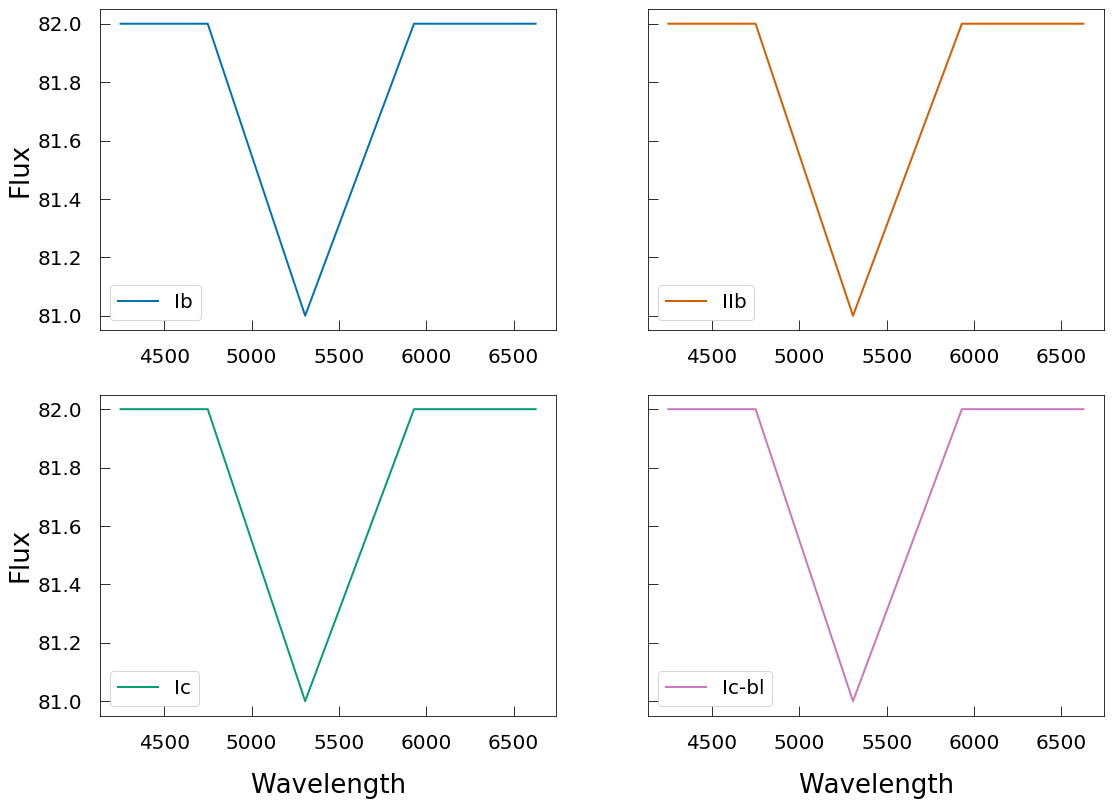

In [5]:
f_all, axs = plt.subplots(2,2,figsize=(18,13), sharey=True, gridspec_kw={'hspace':.2})
axs = axs.flatten()
keys = list(dataset.keys())
wvl_1 = lowres[keys[0]].wavelengths
flux_1 = lowres[keys[0]].data.astype('float64')
wvl_2 = lowres[keys[25]].wavelengths
flux_2 = lowres[keys[25]].data
wvl_3 = lowres[keys[34]].wavelengths
flux_3 = lowres[keys[34]].data
wvl_4 = lowres[keys[50]].wavelengths
flux_4 = lowres[keys[50]].data
axs[0].plot(wvl_1, flux_1, color='b', label ="Ib", linewidth=2)
axs[1].plot(wvl_2, flux_2, color='r', label ="IIb", linewidth=2)
axs[2].plot(wvl_3, flux_3, color='g', label ="Ic", linewidth=2)
axs[3].plot(wvl_4, flux_4, color='m', label ="Ic-bl", linewidth=2)
axs[0].set_ylabel('Flux', fontsize=26)
axs[2].set_ylabel('Flux', fontsize=26)
axs[2].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[3].set_xlabel('Wavelength', fontsize=26, labelpad=20)
axs[0].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[1].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[2].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[3].tick_params(axis='both',which='major', length=10,direction='in',labelsize=20, pad=18)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)

## 2.3 SVM scores

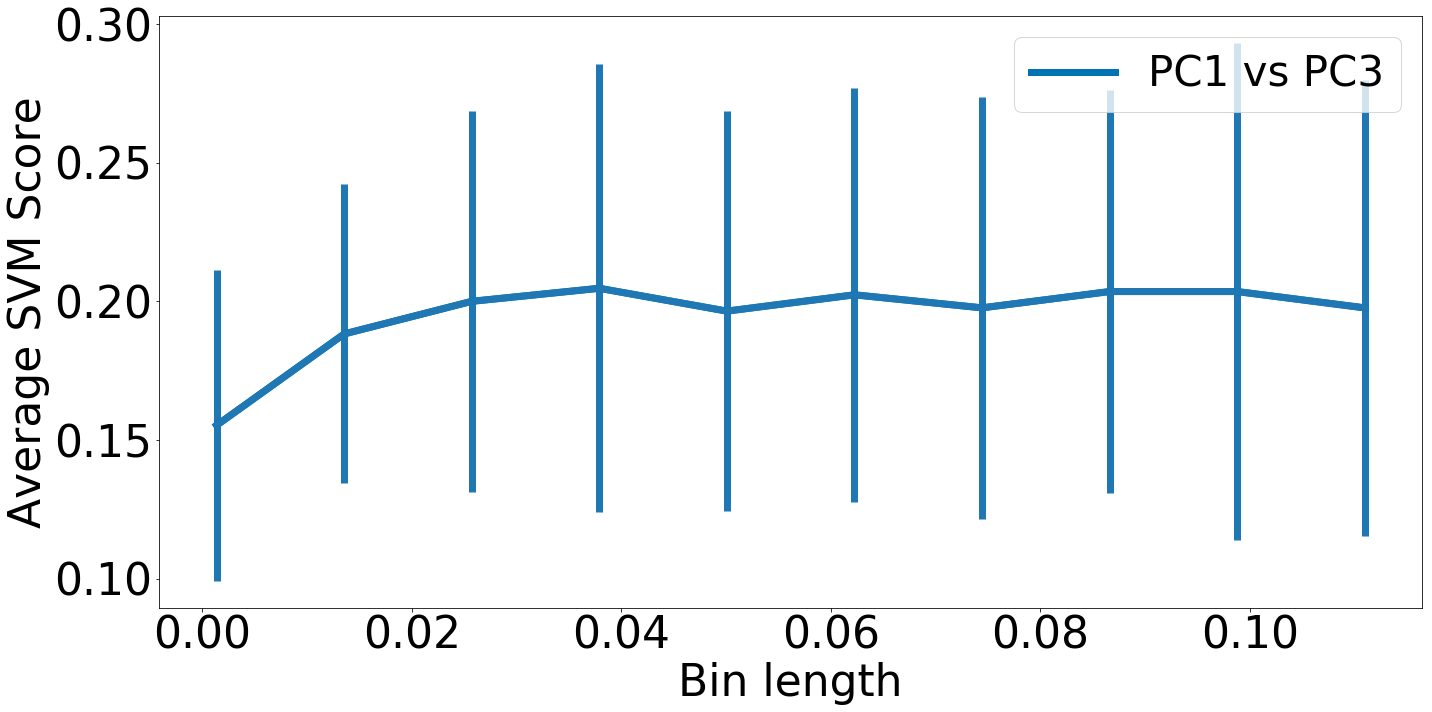

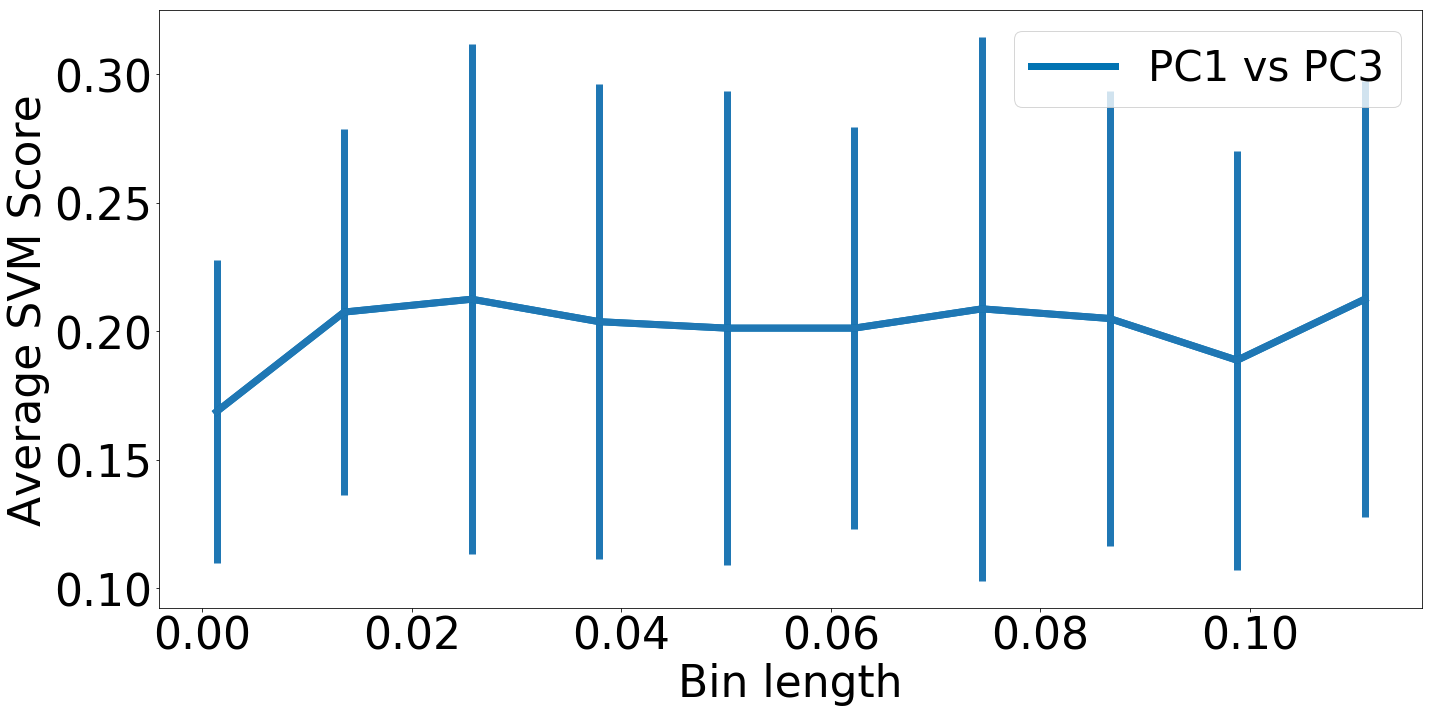

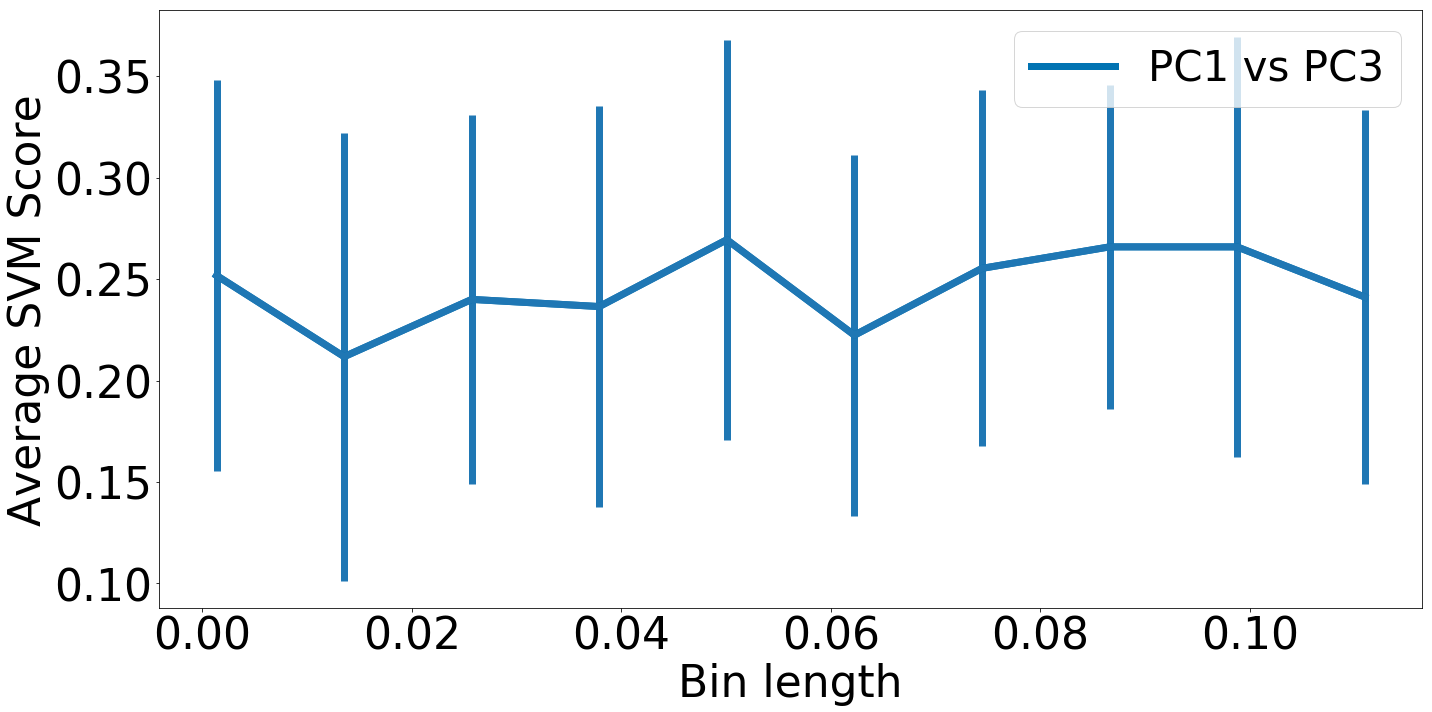

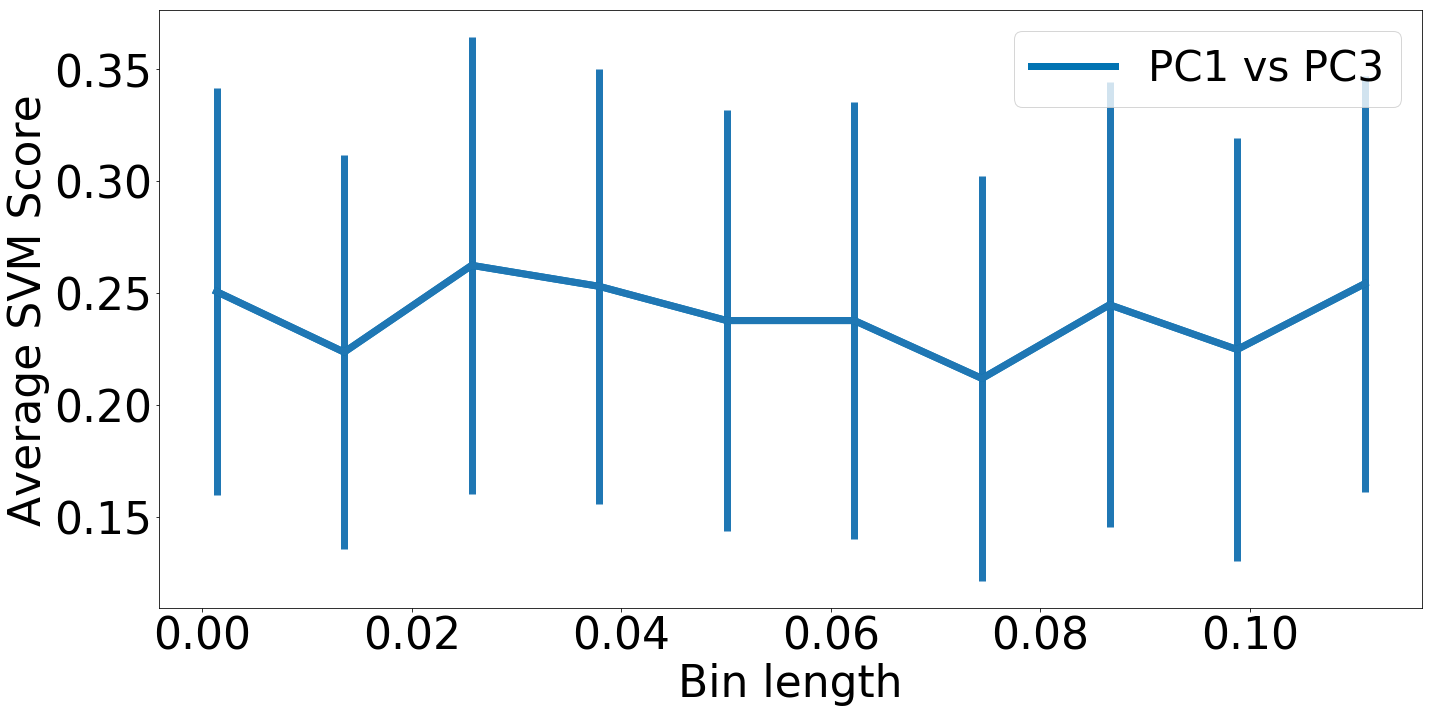

In [6]:
svm_score_0 = runSVM_plot(0, pcax=1, pcay=3)
svm_score_5 = runSVM_plot(5, pcax=1, pcay=3)
svm_score_10 = runSVM_plot(10, pcax=1, pcay=3)
svm_score_15 = runSVM_plot(15, pcax=1, pcay=3)

# 3. Actual spectrum

## Same thing happens in the case of real spectrum. The features stretch out (Become wider) but they are still distinctive and classifier still able to classify them with accuracy score ~ 0.5. At the lowest resolution.